In [57]:
# ===Import Thư Viện===
print("--- Inference from URL - Bắt đầu ---")
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, UnidentifiedImageError 
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import requests 
import io       

print("Inference URL - Libraries imported.")


--- Inference from URL - Bắt đầu ---
Inference URL - Libraries imported.


In [58]:
# ===Xử lý Python Path và Import Model ===
# --- Chạy/Import Định nghĩa Model ResNet ---
print("Inference URL - Loading Model definition...")
try:
    %run ./model_transfer.ipynb 
    _ = get_pretrained_resnet
    print("Inference URL - Hàm get_pretrained_resnet đã được định nghĩa.")
except Exception as e:
    print(f"LỖI khi load/định nghĩa model: {e}")
    exit()

Inference URL - Loading Model definition...
Đã import các thư viện cần thiết
Test model
Test 1: Tạo model với backbone bị đóng băng
Bắt đầu tải model
Đã tải xong model
Đang đóng băng trọng số backbone
Đã đóng băng trọng số backbone
Đang thay thế lớp phân loại cuối cùng
Số lượng đặc trưng đầu vào của lớp phân loại cuối cùng: 2048
Lớp phân loại mới: Linear(in_features=2048, out_features=1, bias=True)
Đã thay thế lớp phân loại cuối cùng
Thông tin về các tham số của model
Tên tham số: fc.weight, kích thước: torch.Size([1, 2048]), requires_grad: True
Tên tham số: fc.bias, kích thước: torch.Size([1]), requires_grad: True
Tổng số tham số có thể huấn luyện: 2049
In ra lớp cuối cùng của model: Linear(in_features=2048, out_features=1, bias=True)
Test 2: Tạo model với backbone không bị đóng băng
Bắt đầu tải model
Đã tải xong model
Không đóng băng trọng số backbone
Đang thay thế lớp phân loại cuối cùng
Số lượng đặc trưng đầu vào của lớp phân loại cuối cùng: 2048
Lớp phân loại mới: Linear(in_featur

In [59]:
# ===Cấu hình Inference ===
print("\nInference URL - Setting up parameters...")
img_size = 224
num_model_classes = 1
class_names = ['cats', 'dogs'] 

# --- Đường dẫn Checkpoint ---
checkpoint_dir = '../checkpoints'
model_filename= 'best_model_resnet.pth' 

checkpoint_path = os.path.join(checkpoint_dir, model_filename)
print(f"Inference URL - Sử dụng checkpoint: {checkpoint_path}")
if not os.path.exists(checkpoint_path):
    print(f"LỖI: File checkpoint không tồn tại: {checkpoint_path}")
    exit()

# --- Xác định Device ---
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device= torch.device("cpu")
print(f"Inference URL - Sử dụng DEVICE: {device}")


Inference URL - Setting up parameters...
Inference URL - Sử dụng checkpoint: ../checkpoints/best_model_resnet.pth
Inference URL - Sử dụng DEVICE: mps


In [60]:
# ===Chuẩn bị Model và Transforms ===
print("\nInference URL - Preparing model and transforms...")

# --- Định nghĩa Inference Transforms ---
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size), 
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])
print("Inference URL - Inference transforms defined.")

# --- Khởi tạo và Load Model ---
model_inference = get_pretrained_resnet(num_classes=num_model_classes, freeze_backbone=False) # Không cần đóng băng khi inference
try:
    model_inference.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("Inference URL - Load trọng số thành công.")
except Exception as e:
    print(f"Lỗi khi load checkpoint: {e}")
    exit()
model_inference.to(device)
model_inference.eval() 
print(f"Inference URL - Model ready on {device} in eval mode.")


Inference URL - Preparing model and transforms...
Inference URL - Inference transforms defined.
Bắt đầu tải model
Đã tải xong model
Không đóng băng trọng số backbone
Đang thay thế lớp phân loại cuối cùng
Số lượng đặc trưng đầu vào của lớp phân loại cuối cùng: 2048
Lớp phân loại mới: Linear(in_features=2048, out_features=1, bias=True)
Đã thay thế lớp phân loại cuối cùng
Thông tin về các tham số của model
Tên tham số: conv1.weight, kích thước: torch.Size([64, 3, 7, 7]), requires_grad: True
Tên tham số: bn1.weight, kích thước: torch.Size([64]), requires_grad: True
Tên tham số: bn1.bias, kích thước: torch.Size([64]), requires_grad: True
Tên tham số: layer1.0.conv1.weight, kích thước: torch.Size([64, 64, 1, 1]), requires_grad: True
Tên tham số: layer1.0.bn1.weight, kích thước: torch.Size([64]), requires_grad: True
Tên tham số: layer1.0.bn1.bias, kích thước: torch.Size([64]), requires_grad: True
Tên tham số: layer1.0.conv2.weight, kích thước: torch.Size([64, 64, 3, 3]), requires_grad: True


In [61]:
# ===Hàm Dự đoán từ URL ===
def predict_from_url(image_url, model, device, transforms_pipeline, class_names_list):
    
    print(f"\nProcessing URL: {image_url}")
    pil_image = None # Khởi tạo để trả về nếu lỗi sớm
    try:
        print("  Downloading image...")
        response = requests.get(image_url, stream=True, timeout=10)
        response.raise_for_status()
        print("  Download successful.")

        # --- Mở ảnh bằng PIL ---
        # Đọc nội dung (bytes) của response và đưa vào io.BytesIO để PIL có thể đọc như file.
        # .convert('RGB') đảm bảo ảnh có 3 kênh màu chuẩn.
        print("  Opening image with PIL...")
        pil_image = Image.open(io.BytesIO(response.content)).convert('RGB')
        print("  Image opened successfully.")

        # --- Tiền xử lý ảnh ---
        print("  Applying transforms...")
        # Áp dụng chuỗi transforms (Resize, Crop, ToTensor, Normalize).
        input_tensor = transforms_pipeline(pil_image)
        # Thêm chiều batch [C, H, W] -> [1, C, H, W].
        input_batch = input_tensor.unsqueeze(0).to(device) # Chuyển lên device.
        print(f"  Input tensor ready, shape: {input_batch.shape}")

        # --- Thực hiện dự đoán ---
        print("  Performing prediction...")
        # Tắt gradient tracking.
        with torch.no_grad():
            # Cho batch qua model.
            output = model(input_batch) # Output là logits [1, 1].

        # --- Xử lý kết quả ---
        print("  Processing result...")
        # Áp dụng sigmoid lên logit để có xác suất P(class=1).
        probability = torch.sigmoid(output).item()
        # Quyết định lớp dự đoán dựa trên ngưỡng 0.5.
        predicted_idx = 1 if probability > 0.5 else 0
        # Lấy tên lớp dự đoán.
        predicted_class = class_names_list[predicted_idx]
        # Tính độ tự tin.
        confidence = probability if predicted_idx == 1 else (1 - probability)
        print("  Prediction processed.")

        # Trả về kết quả dự đoán và ảnh PIL gốc.
        return predicted_class, confidence, pil_image

    # --- Xử lý các loại lỗi có thể xảy ra ---
    except requests.exceptions.RequestException as e: # Lỗi liên quan đến mạng (không kết nối, timeout...).
        print(f"  ERROR downloading image: {e}")
        return None, None, None
    except UnidentifiedImageError: # Lỗi PIL không nhận dạng được định dạng ảnh.
        print(f"  ERROR: Cannot identify image file from URL content.")
        return None, None, None
    except FileNotFoundError: # Thêm lỗi này nếu response thành công nhưng PIL không mở được (hiếm)
         print(f"  ERROR: Image could not be opened by PIL (possibly corrupted data).")
         return None, None, None
    except Exception as e: # Bắt các lỗi không mong muốn khác.
        print(f"  ERROR processing image or predicting: {e}")
        # In traceback để debug nếu cần: import traceback; traceback.print_exc()
        return None, None, None


Processing URL: https://media.baoquangninh.vn/upload/image/202108/medium/1881598_6a3dbaf0450981174884e566ca29bc32.jpg
  Download successful.
  Opening image with PIL...
  Image opened successfully.
  Applying transforms...
  Input tensor ready, shape: torch.Size([1, 3, 224, 224])
  Performing prediction...
  Processing result...
  Prediction processed.


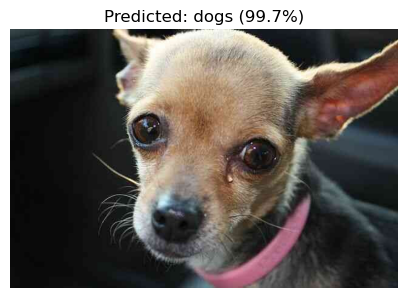


Processing URL: https://nld.mediacdn.vn/thumb_w/698/2015/1-1431397347610.jpg
  Download successful.
  Opening image with PIL...
  Image opened successfully.
  Applying transforms...
  Input tensor ready, shape: torch.Size([1, 3, 224, 224])
  Performing prediction...
  Processing result...
  Prediction processed.


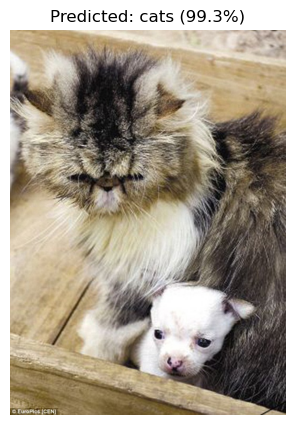


Processing URL: https://example.com/not_an_image.txt
  ERROR downloading image: 404 Client Error: Not Found for url: https://example.com/not_an_image.txt
  -> Skipping display due to previous error.

Processing URL: https://example.com/nonexistent_image.jpg
  ERROR downloading image: 404 Client Error: Not Found for url: https://example.com/nonexistent_image.jpg
  -> Skipping display due to previous error.

--- Inference URL finished ---


In [62]:
# ==Thực thi Inference trên URL Ví dụ ===
if __name__ == '__main__':
    test_url_dog = "https://media.baoquangninh.vn/upload/image/202108/medium/1881598_6a3dbaf0450981174884e566ca29bc32.jpg"
    test_url_cat = "https://nld.mediacdn.vn/thumb_w/698/2015/1-1431397347610.jpg"
    test_url_404 = "https://example.com/nonexistent_image.jpg" 

    urls_to_test = [test_url_dog, test_url_cat, test_url_invalid, test_url_404]

    
    for url in urls_to_test:
        pred_label, conf_score, img_display = predict_from_url(
            url, model_inference, device, inference_transforms, class_names
        )

        # --- Hiển thị kết quả nếu dự đoán thành công ---
        if pred_label is not None and img_display is not None:
            plt.figure(figsize=(5, 5)) 
            plt.imshow(img_display)   
            plt.title(f"Predicted: {pred_label} ({conf_score:.1%})", wrap=True)
            plt.axis('off')
            plt.show() 
        else:
            print("  -> Skipping display due to previous error.")

    print("\n--- Inference URL finished ---") 